In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mnsit-10-19/test_data.csv
/kaggle/input/mnsit-10-19/train.csv
/kaggle/input/mnsit-10-19/submission_format.csv


 # **Importing all libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from sklearn.metrics import confusion_matrix
import itertools 

from keras.utils.np_utils import to_categorical #Converting to one hot encoding 
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from glob import glob
import tensorflow as tf
from keras.utils.np_utils import to_categorical #Converting to one hot encoding 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


# **Setting random seed so that result are reproducible**

In [3]:
seed = 27
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# **Importing train data**

In [4]:
df = pd.read_csv("/kaggle/input/mnsit-10-19/train.csv")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1391,1392,1393,1394,1395,1396,1397,1398,1399,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10


# **Shuffling train data to avoid bias**

In [5]:
df = df.reindex(np.random.permutation(df.index))
df = df.reset_index(drop = True)
# df = df.drop(['index','level_0'], axis = 1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1391,1392,1393,1394,1395,1396,1397,1398,1399,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,15
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,18
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,14
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16


# **Extracting X and Y from data**

In [6]:
X = df.drop(['label'], axis = 1)
y = df['label']

In [7]:
y[0:10]

0    16
1    15
2    18
3    14
4    16
5    16
6    12
7    15
8    19
9    11
Name: label, dtype: int64

# **Reshaping X into (len(X), height, width) to convert 1D array into 2D image array**

In [8]:
X = X.to_numpy().reshape(19999,28,50)

# **Plotting some sample images**

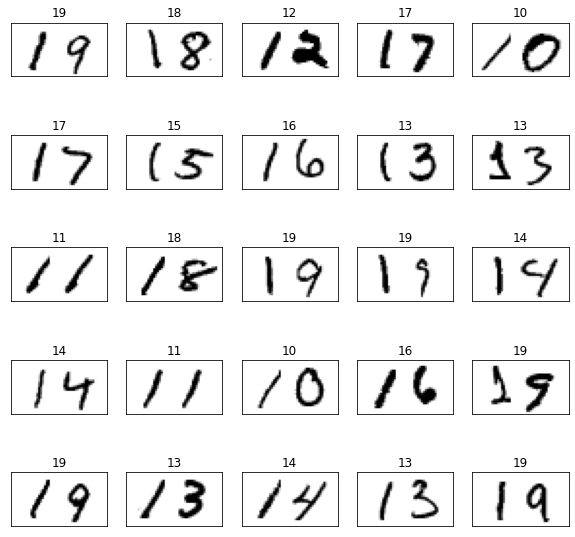

<Figure size 432x288 with 0 Axes>

In [9]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X))
    plt.imshow(X[index], cmap=plt.cm.binary)
    label_index = int(y[index])
    plt.title(label_index)
plt.show()
plt.tight_layout()

# **Plotting images by removing 1**

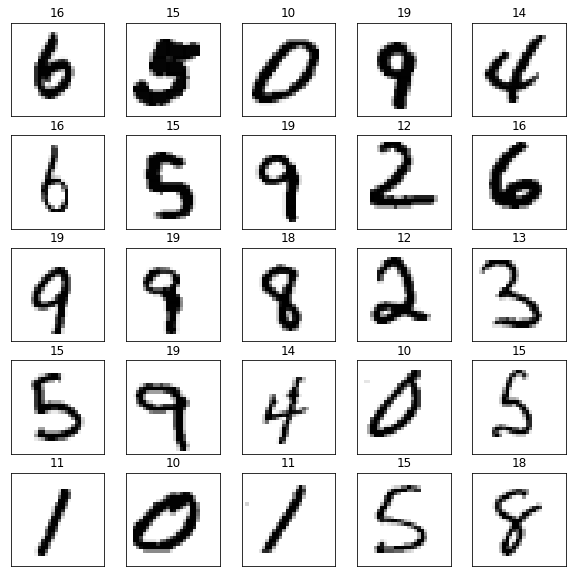

<Figure size 432x288 with 0 Axes>

In [10]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X))
    plt.imshow(X[index][:,22:], cmap=plt.cm.binary)
    label_index = int(y[index])
    plt.title(label_index)
plt.show()
plt.tight_layout()

# **Here we are removing pixels that contain 1 from all images by removing first 22 columns from image array**

In [11]:
X = X[:,:,22:]
X = X.astype("float32")
X = X / 255.0
print("X_train Shape :",X.shape)

X_train Shape : (19999, 28, 28)


# **Plotting images after removing 1 from all images**

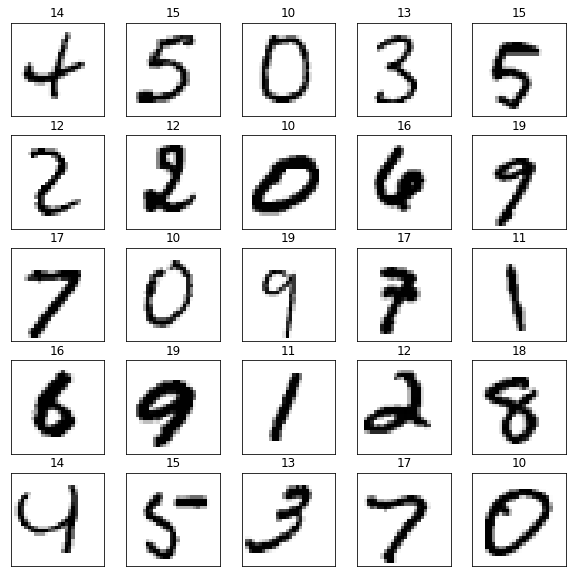

<Figure size 432x288 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X))
    plt.imshow(X[index], cmap=plt.cm.binary)
    label_index = int(y[index])
    plt.title(label_index)
plt.show()
plt.tight_layout()

# **Reshaping X and subtracting 10 from y label to make its range from (10 to 19) to (0 to 9)**

In [13]:
X = X.reshape(-1,28,28,1)
y = y - 10

In [14]:
pd.Series(y).unique()

array([6, 5, 8, 4, 2, 9, 1, 7, 3, 0])

# **Categorically encoding y label using keras**

In [15]:
from keras.utils.np_utils import to_categorical 
y = to_categorical(y,num_classes = 10)


# **Doing train and validation split**

In [16]:
from sklearn.model_selection import train_test_split 
X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size = 0.05,random_state = 27)
print("X_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("Y_train shape",Y_train.shape)
print("Y_val shape",Y_val.shape)


X_train shape (18999, 28, 28, 1)
X_val shape (1000, 28, 28, 1)
Y_train shape (18999, 10)
Y_val shape (1000, 10)


# **Making model to classify images**

In [17]:
cnn_model = Sequential()

cnn_model.add(Conv2D(filters=512, kernel_size=(3, 3), input_shape=(28,28,1), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.2))

cnn_model.add(Flatten())
cnn_model.add(Dense(units=512, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=10, activation='softmax'))

2022-04-24 13:07:52.954645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:07:53.076398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:07:53.077616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-24 13:07:53.079242: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [18]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 512)       5120      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 512)       2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       1179904   
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       2

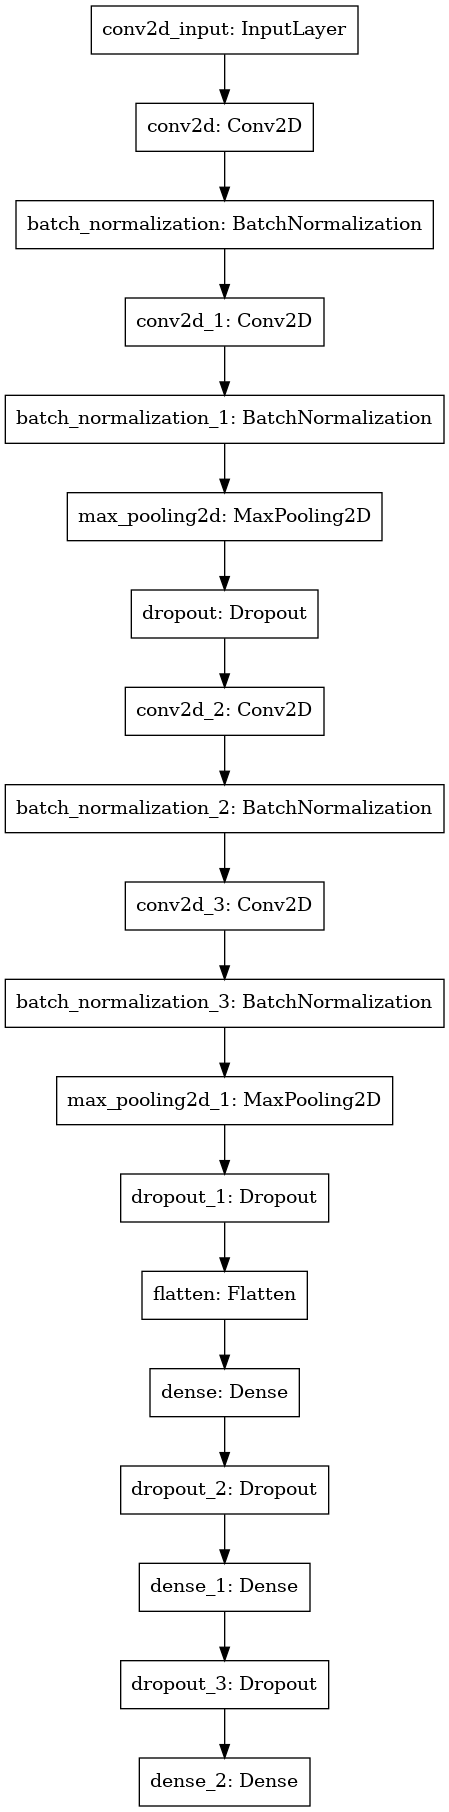

In [19]:
import tensorflow as tf
tf.keras.utils.plot_model(cnn_model, to_file='model.png')

# **Learning rate optimizer callback function**

In [20]:
learning_rate_optimizer = ReduceLROnPlateau(monitor = "val_accuracy",
                                           patience = 2, verbose = 1,
                                           factor = 0.5, min_lr = 0.000001)

# **Compiling model using Adam optimizer and categorical_crossentropy loss**

In [21]:
optimizer = Adam()
cnn_model.compile(optimizer = optimizer, loss  ="categorical_crossentropy", metrics =["accuracy"])

# **Training the model**

In [22]:
batch_size = 512
epochs = 50
history = cnn_model.fit(X_train,Y_train, 
                                epochs = epochs,
                                validation_data = (X_val,Y_val),
                                steps_per_epoch = X_train.shape[0]//batch_size,
                                callbacks = [learning_rate_optimizer])

2022-04-24 13:07:58.654976: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-24 13:08:00.974370: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 21s 278ms/step - loss: 0.9299 - accuracy: 0.7450 - val_loss: 1.7744 - val_accuracy: 0.3670
Epoch 2/50
37/37 [==============================] - 8s 204ms/step - loss: 0.1695 - accuracy: 0.9485 - val_loss: 2.2600 - val_accuracy: 0.2310
Epoch 3/50
37/37 [==============================] - 8s 205ms/step - loss: 0.0978 - accuracy: 0.9704 - val_loss: 2.5536 - val_accuracy: 0.2120

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/50
37/37 [==============================] - 8s 204ms/step - loss: 0.0688 - accuracy: 0.9785 - val_loss: 2.5879 - val_accuracy: 0.2280
Epoch 5/50
37/37 [==============================] - 8s 203ms/step - loss: 0.0543 - accuracy: 0.9832 - val_loss: 2.5173 - val_accuracy: 0.2980

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/50
37/37 [==============================] - 8s 206ms/step - loss: 0.0462 - accuracy: 0.9847 - val_loss: 2.2487 - val_accuracy: 0.4

# **Plotting graph of loss and accuracy**

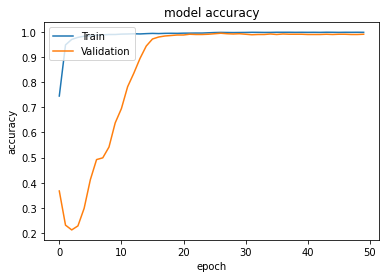

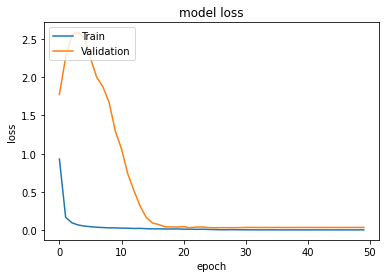

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **For test data**

# **Importing test data**

In [24]:
df_test = pd.read_csv("/kaggle/input/mnsit-10-19/test_data.csv")
df_test.head()

,image_id,0,1,2,3,4,5,6,7,8,...,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_test.shape

(976, 1401)

In [26]:
X_test = df_test.drop(['image_id'], axis = 1)

In [27]:
X_test = X_test.to_numpy().reshape(976,28,50)

# **Plotting test images**

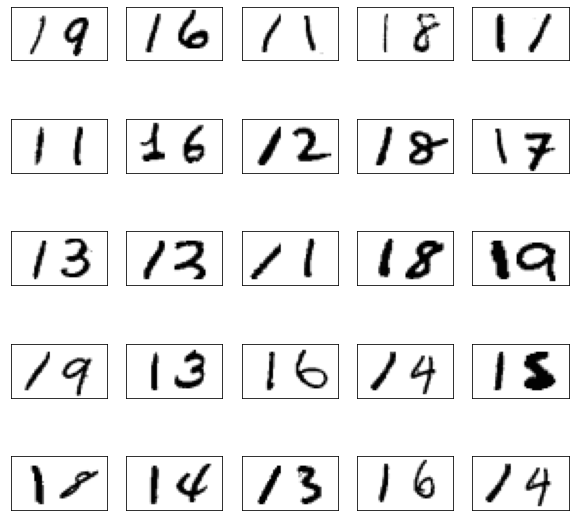

<Figure size 432x288 with 0 Axes>

In [28]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X_test))
    plt.imshow(X_test[index], cmap=plt.cm.binary)
plt.show()
plt.tight_layout()

# **Removing pixels of 1 from test images**

In [29]:
X_test = X_test[:,:,22:]
X_test = X_test.astype("float32")
X_test = X_test / 255.0
print("X_train Shape :",X_test.shape)

X_train Shape : (976, 28, 28)


# **Plotting images by removing 1**

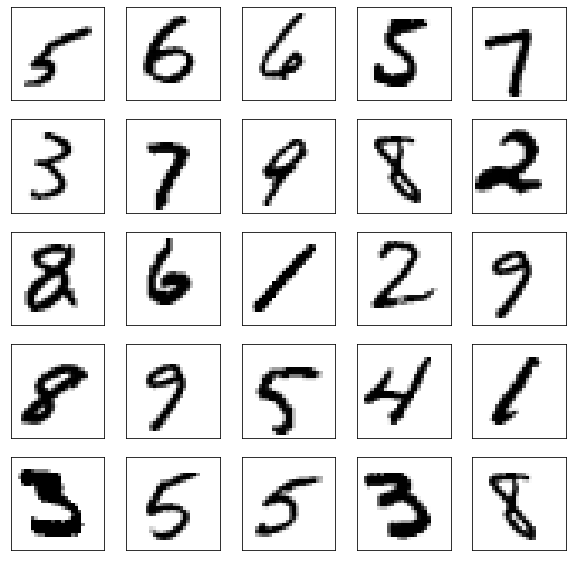

<Figure size 432x288 with 0 Axes>

In [30]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X_test))
    plt.imshow(X_test[index], cmap=plt.cm.binary)
#     label_index = int(y[index])
#     plt.title(label_index)
plt.show()
plt.tight_layout()

In [31]:
X_test = X_test.reshape(-1,28,28,1)


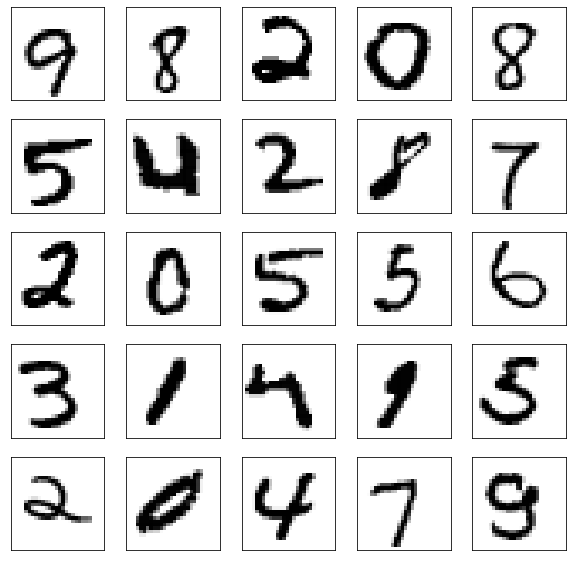

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X_test))
    plt.imshow(X_test[index], cmap=plt.cm.binary)

plt.show()
plt.tight_layout()

In [33]:
X_test.shape

(976, 28, 28, 1)

# **Doing prediction on test data**

In [34]:
y_pred = cnn_model.predict(X_test)

In [35]:
y_pred

array([[1.4921189e-09, 1.6848785e-09, 1.2218647e-08, ..., 1.0000000e+00,
        6.4903818e-11, 2.1507722e-08],
       [1.0000000e+00, 1.3356741e-08, 5.2382725e-09, ..., 1.3859008e-09,
        1.2529006e-09, 2.4604249e-10],
       [9.9999464e-01, 2.8029760e-08, 1.2483807e-07, ..., 2.7974240e-10,
        4.5128271e-08, 3.3836842e-09],
       ...,
       [1.8656467e-11, 5.1207694e-11, 1.0000000e+00, ..., 3.5426618e-13,
        7.3410739e-10, 2.1629881e-14],
       [5.2601916e-07, 1.5753958e-09, 5.5611299e-10, ..., 5.9294430e-10,
        4.6805329e-09, 1.8616888e-08],
       [1.7823707e-08, 3.1146556e-08, 3.1601144e-09, ..., 3.9964522e-08,
        9.5804658e-08, 2.9822817e-07]], dtype=float32)

In [36]:
y_pred.shape

(976, 10)

In [37]:
y_pred_max = np.argmax(y_pred, axis= 1)

# **Plotting result on test data**

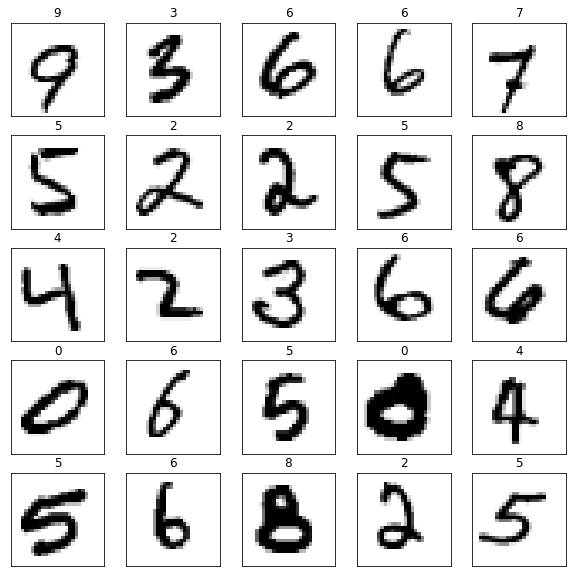

<Figure size 432x288 with 0 Axes>

In [38]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X_test))
    plt.imshow(X_test[index], cmap=plt.cm.binary)
    label_index = int(y_pred_max[index])
    plt.title(label_index)
plt.show()
plt.tight_layout()

In [39]:
y_pred_max

array([7, 0, 0, 1, 1, 6, 0, 7, 0, 4, 9, 5, 4, 6, 6, 5, 6, 4, 5, 1, 6, 8,
       5, 7, 3, 4, 0, 8, 1, 3, 8, 2, 1, 1, 2, 8, 6, 0, 7, 9, 3, 5, 6, 7,
       2, 9, 9, 5, 8, 0, 5, 7, 1, 1, 2, 4, 1, 4, 5, 8, 3, 3, 7, 2, 0, 4,
       1, 1, 9, 0, 4, 7, 9, 3, 1, 5, 4, 0, 5, 1, 4, 3, 7, 1, 6, 2, 9, 1,
       5, 8, 2, 4, 8, 8, 7, 7, 7, 0, 2, 2, 3, 0, 3, 7, 0, 4, 3, 2, 8, 0,
       8, 7, 8, 3, 6, 0, 6, 6, 0, 7, 6, 5, 5, 6, 9, 4, 2, 9, 7, 0, 3, 3,
       5, 6, 3, 6, 8, 4, 9, 9, 2, 4, 3, 4, 3, 2, 4, 1, 1, 8, 8, 5, 9, 3,
       6, 1, 0, 2, 0, 7, 2, 4, 8, 5, 5, 6, 5, 0, 6, 9, 8, 7, 9, 3, 1, 1,
       4, 0, 9, 2, 6, 2, 2, 7, 0, 7, 4, 0, 5, 6, 8, 6, 9, 9, 8, 1, 1, 8,
       3, 5, 2, 8, 0, 9, 2, 1, 8, 7, 5, 9, 3, 3, 5, 4, 0, 1, 0, 3, 4, 4,
       0, 2, 6, 9, 0, 4, 5, 6, 9, 3, 4, 6, 2, 3, 4, 2, 6, 2, 0, 1, 5, 1,
       9, 8, 9, 3, 7, 9, 4, 6, 3, 6, 6, 7, 4, 2, 7, 4, 8, 1, 6, 8, 8, 8,
       6, 9, 6, 5, 9, 5, 3, 2, 7, 8, 2, 0, 6, 8, 6, 2, 0, 1, 5, 7, 7, 2,
       4, 0, 6, 2, 1, 4, 5, 3, 2, 1, 3, 0, 8, 2, 8,

# **Adding 10 on final prediction**

In [40]:
y_pred_max = y_pred_max + 10

# **Plotting results**

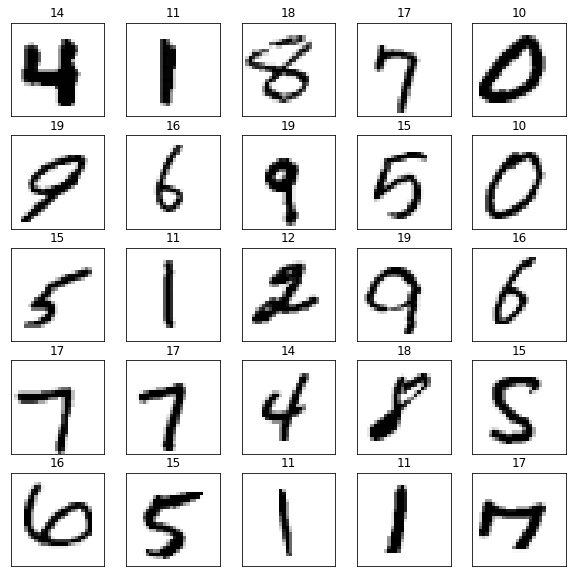

<Figure size 432x288 with 0 Axes>

In [41]:
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(0, len(X_test))
    plt.imshow(X_test[index], cmap=plt.cm.binary)
    label_index = int(y_pred_max[index])
    plt.title(label_index)
plt.show()
plt.tight_layout()

In [42]:
y_pred_max

array([17, 10, 10, 11, 11, 16, 10, 17, 10, 14, 19, 15, 14, 16, 16, 15, 16,
       14, 15, 11, 16, 18, 15, 17, 13, 14, 10, 18, 11, 13, 18, 12, 11, 11,
       12, 18, 16, 10, 17, 19, 13, 15, 16, 17, 12, 19, 19, 15, 18, 10, 15,
       17, 11, 11, 12, 14, 11, 14, 15, 18, 13, 13, 17, 12, 10, 14, 11, 11,
       19, 10, 14, 17, 19, 13, 11, 15, 14, 10, 15, 11, 14, 13, 17, 11, 16,
       12, 19, 11, 15, 18, 12, 14, 18, 18, 17, 17, 17, 10, 12, 12, 13, 10,
       13, 17, 10, 14, 13, 12, 18, 10, 18, 17, 18, 13, 16, 10, 16, 16, 10,
       17, 16, 15, 15, 16, 19, 14, 12, 19, 17, 10, 13, 13, 15, 16, 13, 16,
       18, 14, 19, 19, 12, 14, 13, 14, 13, 12, 14, 11, 11, 18, 18, 15, 19,
       13, 16, 11, 10, 12, 10, 17, 12, 14, 18, 15, 15, 16, 15, 10, 16, 19,
       18, 17, 19, 13, 11, 11, 14, 10, 19, 12, 16, 12, 12, 17, 10, 17, 14,
       10, 15, 16, 18, 16, 19, 19, 18, 11, 11, 18, 13, 15, 12, 18, 10, 19,
       12, 11, 18, 17, 15, 19, 13, 13, 15, 14, 10, 11, 10, 13, 14, 14, 10,
       12, 16, 19, 10, 14

In [43]:
df_test['label'] = y_pred_max 

In [44]:
df_test.head()

,image_id,0,1,2,3,4,5,6,7,8,...,1391,1392,1393,1394,1395,1396,1397,1398,1399,label
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11


# **Making dataframe for final prediction**

In [45]:
df_final = df_test[['image_id', 'label']]

In [46]:
df_final.head()

,image_id,label
0,0,17
1,1,10
2,2,10
3,3,11
4,4,11


# **Making CSV for final prediction**

In [47]:
df_final.to_csv("final.csv", index = False)